In [1]:
from validphys.api import API
import numpy as np
import pandas as pd

# fitname = "240108-01-rs-ht-tcm-disonly" # ht_coeff = 2.5
# fitname = "240109-01-rs-ht-tcm-disonly" # ht_coeff = 1.0 | -0.02256 ± 0.02550
# fitname = "240109-02-rs-ht-tcm-disonly" # ht_coeff = 1.0, iterated | -0.03457 ± 0.02597
fitname = "240109-03-rs-ht-tcm-disonly" # ht_coeff = 2.5, iterated | 0.61057 ± 0.02822
# fitname = "240109-04-rs-ht-tcm-disonly" # 240109-02-rs-ht-tcm-disonly with lowered cuts | 0.21670 ± 0.01147
# fitname = "240110-01-rs-ht-tcm-disonly" # 240109-02-rs-ht-tcm-disonly with highered cuts | 0.05157 ± 0.07621

In [2]:
ht_coeff = API.fit(fit=fitname).as_input()["theorycovmatconfig"]["ht_coeff"]

# dict used to produce theory predictions to construct the theory covmat as well as to produce
# theory predictions from the fit performed using the ht covmat (i.e. the predicitons that should
# be compared to data)
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

In [3]:
# collect the information (predictions + kinematics) needed for the computation of the HT covmat

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)
preds_ht_cov_construction = API.group_result_table_no_table(**(S_dict | common_dict))

# collect the corresponding kinemacs
process_info = API.combine_by_type_ht(**(S_dict | common_dict))
kinematics = np.concatenate([v for v in process_info.data.values()]).T
xvals = kinematics[0]
q2vals = kinematics[1]

LHAPDF 6.5.0 loading /home/roy/miniconda3/envs/nnpdf/share/LHAPDF/240108-01-rs-ht-tcm-disonly/240108-01-rs-ht-tcm-disonly_0000.dat
240108-01-rs-ht-tcm-disonly PDF set, member #0, version 1
LHAPDF 6.5.0 loading all 501 PDFs in set 240108-01-rs-ht-tcm-disonly
240108-01-rs-ht-tcm-disonly, version 1; 501 PDF members


In [4]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.0 loading all 501 PDFs in set 240109-03-rs-ht-tcm-disonly
240109-03-rs-ht-tcm-disonly, version 1; 501 PDF members


In [5]:
# compute the matrix X encoding the PDF uncertainties of the predictions

preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

X = np.zeros((preds.shape[0], preds.shape[0]))
for i in range(preds_onlyreplicas.shape[1]):
    X += np.outer(
        (preds_onlyreplicas[:, i] - mean_prediction), (preds_onlyreplicas[:, i] - mean_prediction)
    )
X *= 1 / preds_onlyreplicas.shape[1]

In [6]:
# compute the delta of the theory prediction
delta_pred = ht_coeff * (
    preds_ht_cov_construction["theory_central"] / q2vals / (1 - xvals)
)

In [7]:
# Theory covariance matrix
S = np.outer(delta_pred, delta_pred)
S = pd.DataFrame(S, index=delta_pred.index, columns=delta_pred.index)

# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

# Ensure that S anc C are ordered in the same way (in practice they already are)
S = S.reindex(C.index).T.reindex(C.index)

In [8]:
# Load the central value of the pseudodata
# this is needed to compute the distance between prediction and data
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [9]:
# Compute delta_T_tilde (Eq. 3.37) and P_tilde (Eq. 3.38) of arXiv:2105.05114

# The factors 1/sqrt(2) are to normalize for the fact that beta provides information about
# theoretical uncertainties along two directions
beta_tilde = ht_coeff * np.sqrt(1/2) * np.array([1, -1])
S_tilde = beta_tilde @ beta_tilde
beta = np.sqrt(1/2) * np.array([delta_pred, -delta_pred])
S_hat = beta_tilde @ beta

invcov = np.linalg.inv(C + S)

delta_T_tilde = -S_hat @ invcov @ (mean_prediction - dat_central)
# where are the X_tilde and X_hat terms in P_tilde?
# Maybe not present because we don't have correlations between theory parameters
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat + (S_tilde - S_hat @ invcov @ S_hat)
ht_coeff_central = 0.0
pred = ht_coeff_central + delta_T_tilde
unc = np.sqrt(P_tilde)

In [10]:
# check if the stored covmat is equal to S we recomputed above
fitpath = API.fit(fit=fitname).path
try:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_user_covmat.csv",
        sep="\t",
        encoding="utf-8",
        index_col=2,
        header=3,
        skip_blank_lines=False,
    )
except FileNotFoundError:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
        index_col=[0, 1, 2],
        header=[0, 1, 2],
        sep="\t|,",
        engine="python",
    ).fillna(0)
    storedcovmat_index = pd.MultiIndex.from_tuples(
        [(aa, bb, np.int64(cc)) for aa, bb, cc in stored_covmat.index],
        names=["group", "dataset", "id"],
    )
    stored_covmat = pd.DataFrame(
        stored_covmat.values, index=storedcovmat_index, columns=storedcovmat_index
    )
    stored_covmat = stored_covmat.reindex(S.index).T.reindex(S.index)

# print the final result
if np.allclose(S, stored_covmat):
    print(rf"Prediction for ht_coeff: {pred:.5f} ± {unc:.5f}")
else:
    print("Reconstructed theory covmat, S, is not the same as the stored covmat!")

Prediction for ht_coeff: 0.61057 ± 0.02822


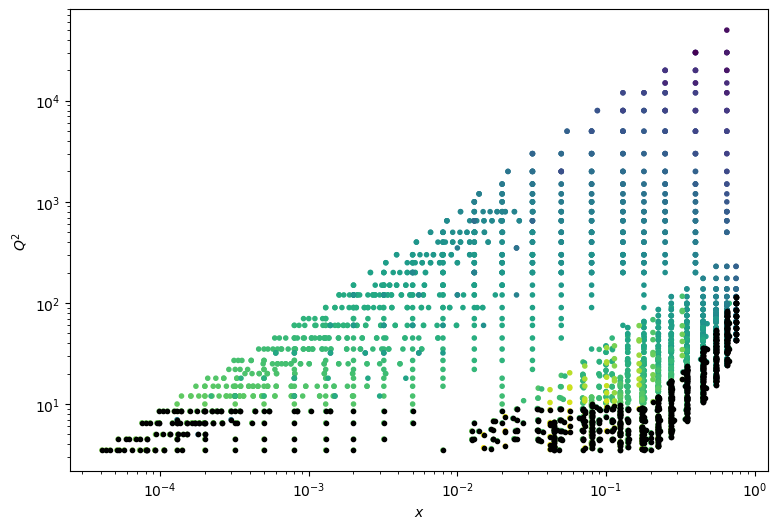

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(
    xvals,
    q2vals,
    marker=".",
    c=stored_covmat.to_numpy().diagonal(),
    cmap="viridis",
    norm=mcolors.LogNorm(),
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$Q^2$");

filterlist = []
q2min = 10
w2min = 45
for i,(x,q2) in enumerate(zip(xvals, q2vals)):
    w2 = q2*(1-x)/x
    if q2 < q2min:
        filterlist.append(i)
    elif w2 < w2min:
        filterlist.append(i)

ax.scatter(
    xvals[filterlist],
    q2vals[filterlist],
    marker=".",
    color="black"
)


/home/roy/github/NNPDF/nnpdf/validphys2/src/validphys/plotoptions/kintransforms.py:238: RuntimeWarning: divide by zero encountered in divide
  ecm = np.sqrt(k2 / (k1 * k3))
/home/roy/github/NNPDF/nnpdf/validphys2/src/validphys/plotoptions/kintransforms.py:238: RuntimeWarning: divide by zero encountered in divide
  ecm = np.sqrt(k2 / (k1 * k3))
/home/roy/github/NNPDF/nnpdf/validphys2/src/validphys/plotoptions/kintransforms.py:238: RuntimeWarning: divide by zero encountered in divide
  ecm = np.sqrt(k2 / (k1 * k3))


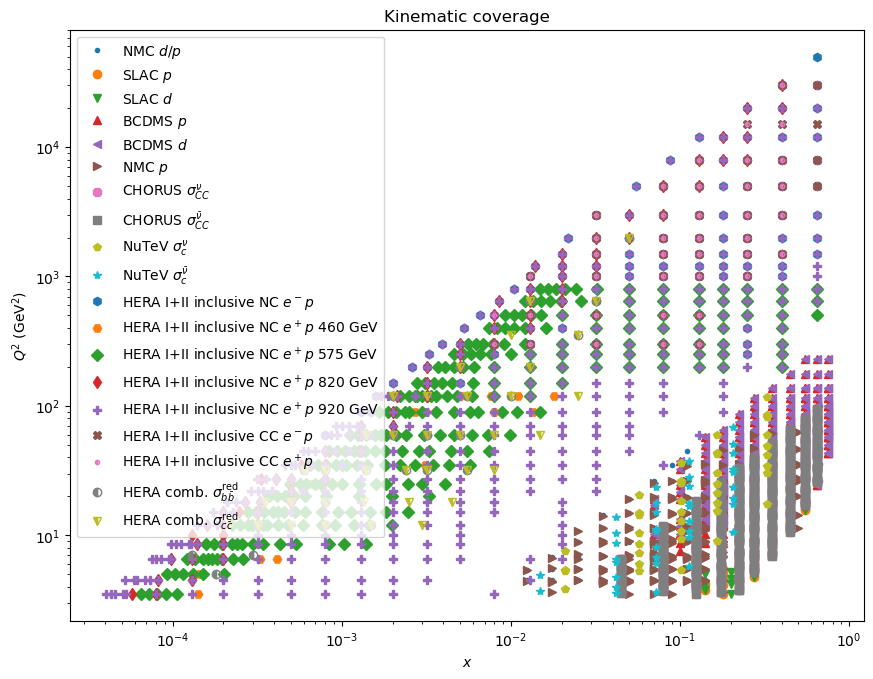

In [12]:
API.plot_xq2(
    fit=fitname,
    dataset_inputs={"from_": "fit"},
    use_cuts="fromfit",
    display_cuts=False,
    marker_by="dataset",
)